# 1. Load dataset and environemnt setup
### Section 1.1: libraries import and data path

In [5]:
import numpy as np
import librosa
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Paths for dataset and label files
# DATASET_PATH specifies the location of the audio files (.flac format).
# LABEL_FILE_PATH points to the protocol file that contains labels (e.g., bona fide or spoof) for each audio file.
DATASET_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

# Paths for test dataset and label files
# TEST_DATASET_PATH specifies the location of the evaluation audio files (.flac format).
# TEST_LABEL_FILE_PATH points to the protocol file for the evaluation data.
TEST_DATASET_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_dev/flac"
TEST_LABEL_FILE_PATH = "/mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"

### Section 1.2: function to extract mfcc features

In [6]:
# Extract features from audio files
def extract_features(file_path, n_mfcc=20):
    """
    Extract MFCC (Mel-Frequency Cepstral Coefficients) features from an audio file.
    
    Steps:
    1. Load the audio file using librosa.
    2. Compute the MFCCs, which capture the spectral characteristics of the audio.
    3. Take the mean of the MFCC coefficients across the time axis to summarize the audio into a fixed-length feature vector.

    Args:
        file_path (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to compute.

    Returns:
        np.ndarray: A fixed-length feature vector representing the audio.
    """
    y, sr = librosa.load(file_path, sr=None)  # Load the audio signal and its sampling rate.
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Compute MFCC features.
    return np.mean(mfcc.T, axis=0)  # Return the mean MFCC values across time.

### Section 1.3: function ti load labels file

In [7]:
# Load labels from the label file
def load_labels(label_file):
    """
    Load labels from a protocol file. The protocol file contains mappings between file IDs and their corresponding labels.

    Args:
        label_file (str): Path to the protocol file.

    Returns:
        dict: A dictionary mapping file IDs to labels (e.g., bona fide or spoof).
    """
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()  # Split the line into parts.
            file_id, label = parts[1], parts[-1]  # Extract file ID and label.
            labels[file_id] = label
    return labels

### Section 1.4 function to load files with librosa

In [8]:
def load_and_preprocess_data(dataset_path, label_file):
    """
    Load audio data and extract features based on the provided label file.

    Steps:
    1. Load labels using the `load_labels` function.
    2. Iterate through all .flac files in the dataset directory.
    3. For each file, extract features and retrieve the corresponding label from the protocol file.

    Args:
        dataset_path (str): Path to the directory containing audio files.
        label_file (str): Path to the protocol file with labels.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: Extracted features for all audio files.
            - np.ndarray: Corresponding labels for the audio files.
    """
    labels = load_labels(label_file)  # Load the labels.
    features = []
    labels_list = []

    for file in tqdm(os.listdir(dataset_path), desc="Processing audio files", unit="file"):
        if file.endswith(".flac"):  # Check if the file is a .flac audio file.
            file_path = os.path.join(dataset_path, file)  # Construct the full file path.
            file_id = file.replace(".flac", "")  # Extract the file ID (without extension).

            if file_id in labels:  # Check if the file ID exists in the labels.
                features.append(extract_features(file_path))  # Extract features from the audio file.
                labels_list.append(labels[file_id])  # Append the corresponding label.
            else:
                print(f"Warning: File ID '{file_id}' not found in the label file. Skipping.")

    return np.array(features), np.array(labels_list)

### Section 1.5: load training set and its labels

In [9]:
# Load and preprocess the dataset
print("Loading training data...")
train_features, train_labels = load_and_preprocess_data(DATASET_PATH, LABEL_FILE_PATH)

# Scale features
# Standardize the features to have zero mean and unit variance for better performance in SVM.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

# Separate bona fide and spoof data
# One-Class SVM is trained only on bona fide data to model genuine behavior.
bona_fide_features = train_features[train_labels == "bonafide"]

Loading training data...


Processing audio files: 100%|██████████████████████████████████████████████████| 25380/25380 [03:59<00:00, 106.15file/s]


# 2. Define One Class SVM
### Section 2.1: Definition

In [10]:
# Train One-Class SVM
print("Training One-Class SVM...")
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.5)  # Use RBF kernel with scale gamma and nu parameter.
ocsvm.fit(bona_fide_features)  # Train the SVM using bona fide data.

Training One-Class SVM...


OneClassSVM()

### Section 2.2 Load testset and scale it

In [11]:
# Load and preprocess the test dataset
print("Loading test data...")
test_features, test_labels = load_and_preprocess_data(TEST_DATASET_PATH, TEST_LABEL_FILE_PATH)
test_features = scaler.transform(test_features)  # Standardize test features using the same scaler as training.

Loading test data...


Processing audio files: 100%|███████████████████████████████████████████████████| 24986/24986 [04:30<00:00, 92.46file/s]


### Section 2.3: Predict testset labels

In [12]:
# Evaluate on the test dataset
print("Evaluating model on test data...")
test_scores = ocsvm.decision_function(test_features)  # Compute decision scores for test data.
test_predictions = ocsvm.predict(test_features)  # Predict whether each sample is bona fide or spoof.

# Map predictions to binary labels
# Map SVM predictions (1 = inlier, -1 = outlier) to binary labels (1 = bona fide, 0 = spoof).
predicted_labels_test = (test_predictions == 1).astype(int)
actual_labels_test = (test_labels == "bonafide").astype(int)  # Convert actual labels to binary format.



Evaluating model on test data...


### Section 2.4: Show confusion matrix

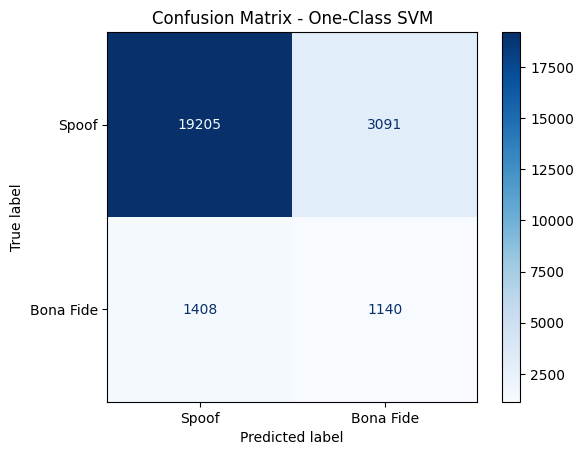

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(actual_labels_test, predicted_labels_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bona Fide"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - One-Class SVM")
plt.show()


### Section 2.6: Show ROC

Test ROC AUC Score: 0.7949


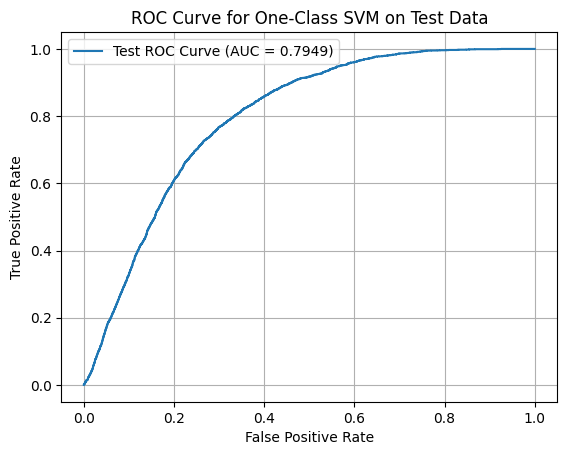

Model and scaler saved successfully.


In [13]:
# Compute ROC AUC for test data
roc_auc_test = roc_auc_score(actual_labels_test, test_scores)
print(f"Test ROC AUC Score: {roc_auc_test:.4f}")

# Plot ROC Curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(actual_labels_test, test_scores)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {roc_auc_test:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for One-Class SVM on Test Data")
plt.legend()
plt.grid()
plt.show()

# Save the model and scaler
# Persist the trained model and the scaler for future use.
with open("one_class_svm_model.pkl", "wb") as model_file:
    pickle.dump(ocsvm, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully.")


### Section 2.7: Save the model

In [14]:
# Save the model and scaler
# Persist the trained model and the scaler for future use.
with open("OC_SVM_First_Model.pkl", "wb") as model_file:
    pickle.dump(ocsvm, model_file)

print("Model and scaler saved successfully.")


Model and scaler saved successfully.
